# Q6 - Bank Customer Clustering

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from math import pi
tqdm.pandas()

## 2. Load Data

In [2]:
bank_customer = pd.read_csv("../Data_Q6/Bank_Customer.csv")

In [3]:
print("Shape of the dataset:", bank_customer.shape)
bank_customer.head()

Shape of the dataset: (1048567, 9)


,TransactionID,CustomerID,CustomerDateOfBirth,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2002/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2002/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2002/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2002/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2002/8/16,181156,1762.5


## 3. Data Preprocessing

In [4]:
# Check missing values
print("Missing values in the dataset before dropping: \n", bank_customer.isnull().sum())

# Drop missing values
bank_customer.dropna(inplace=True)

# Check missing values
print("Missing values in the dataset after dropping: \n", bank_customer.isnull().sum())

Missing values in the dataset before dropping: 
 TransactionID                 0
CustomerID                    0
CustomerDateOfBirth        3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64
Missing values in the dataset after dropping: 
 TransactionID              0
CustomerID                 0
CustomerDateOfBirth        0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


In [5]:
# Drop duplicates
print("Shape of the dataset before dropping duplicates:", bank_customer.shape)
bank_customer.drop_duplicates(inplace=True)
print("Shape of the dataset after dropping duplicates:", bank_customer.shape)

Shape of the dataset before dropping duplicates: (1041614, 9)
Shape of the dataset after dropping duplicates: (1041614, 9)


In [6]:
# Function to check if the date is in the correct format '%d/%m/%y'
def is_correct_format(date_str):
    try:
        datetime.strptime(date_str, '%d/%m/%y')
        return True
    except ValueError:
        return False

# Check the format for each date in the CustomerDateOfBirth column
bank_customer['IsValidDate'] = bank_customer['CustomerDateOfBirth'].apply(is_correct_format)

# Drop rows where the date format is incorrect
print("Shape of the dataset before dropping invalid dates:", bank_customer.shape)
bank_customer = bank_customer[bank_customer['IsValidDate']]
print("Shape of the dataset after dropping invalid dates:", bank_customer.shape)

# Drop the temporary IsValidDate column
bank_customer = bank_customer.drop(columns=['IsValidDate'])
bank_customer.head()

Shape of the dataset before dropping invalid dates: (1041614, 10)
Shape of the dataset after dropping invalid dates: (984425, 10)


,TransactionID,CustomerID,CustomerDateOfBirth,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2002/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2002/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2002/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2002/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2002/8/16,181156,1762.5


In [7]:
# Print Max and min TransactionTime
print("Max TransactionTime:", bank_customer['TransactionTime'].max())
print("Min TransactionTime:", bank_customer['TransactionTime'].min())

Max TransactionTime: 235959
Min TransactionTime: 0


In [8]:
def convert_date(date_str):
    # Parse the date
    date = datetime.strptime(date_str, '%d/%m/%y')
    
    # Set a cutoff for deciding the century
    cutoff_year = 23  # Assuming the current year's last two digits
    if date.year > 2000 + cutoff_year:
        date = date.replace(year=date.year - 100)
    return date

# Apply the modified conversion function
bank_customer['CustomerDateOfBirth'] = bank_customer['CustomerDateOfBirth'].apply(convert_date)
bank_customer['TransactionDate'] = pd.to_datetime(bank_customer['TransactionDate'])
bank_customer['CustomerAge'] = bank_customer['TransactionDate'].dt.year - bank_customer['CustomerDateOfBirth'].dt.year

In [9]:
def convert_time(time_int):
    # Convert to string and pad with leading zeros if necessary
    time_str = str(time_int).zfill(6)

    # Extract hours, minutes, and seconds
    hours = time_str[:2]
    minutes = time_str[2:4]
    seconds = time_str[4:6]

    # Format as HH:MM:SS
    return f"{hours}:{minutes}:{seconds}"

# Function to combine date and time into a single datetime object
def combine_date_time(date, time_str):
    # Format the time string as HH:MM:SS
    formatted_time = convert_time(time_str)
    # Combine date and time
    return pd.to_datetime(f'{date} {formatted_time}')

# Apply the combined function to the DataFrame
bank_customer['TransactionDateTime'] = bank_customer.apply(lambda row: combine_date_time(row['TransactionDate'], row['TransactionTime']), axis=1)

In [10]:
bank_customer['TransactionDate'].value_counts()

TransactionDate
2007-08-16    25997
2013-08-16    25451
2004-09-16    25372
2006-08-16    25248
2003-09-16    25094
2010-09-16    24409
2011-09-16    24287
2014-08-16    24240
2015-08-16    22977
2021-08-16    21642
2002-09-16    21526
2012-08-16    21090
2001-09-16    21001
2009-08-16    20473
2011-08-16    20440
2008-09-16    20424
2010-08-16    20341
2009-09-16    20292
2027-08-16    20108
2020-08-16    20014
2005-09-16    20008
2007-09-16    19887
2005-08-16    19875
2028-08-16    19851
2017-08-16    19745
2008-08-16    19622
2002-08-16    19614
2004-08-16    19408
2013-09-16    19374
2012-09-16    19358
2003-08-16    19259
2001-08-16    19193
2016-08-16    19048
2014-09-16    18558
2015-09-16    18460
2006-09-16    18424
1931-08-16    18349
2018-08-16    18285
2019-08-16    17378
2022-08-16    17328
2025-08-16    17321
2024-08-16    16634
2026-08-16    16445
1930-08-16    16095
2023-08-16    16038
2029-08-16    15524
2018-09-16    13886
2026-09-16    11526
2025-09-16     7759
2027

In [11]:
# Drop the date before 2000-01-01
print("Shape of the dataset before dropping invalid dates:", bank_customer.shape)
bank_customer = bank_customer[bank_customer['TransactionDate'] >= '2000-01-01']
print("Shape of the dataset after dropping invalid dates:", bank_customer.shape)

Shape of the dataset before dropping invalid dates: (984425, 11)
Shape of the dataset after dropping invalid dates: (948159, 11)


In [12]:
# Drop the unnecessary columns
bank_customer = bank_customer.drop(columns=['TransactionDate', 'TransactionTime', 'CustomerDateOfBirth'])

In [13]:
# Drop Age <= 0
print("Shape of the dataset before dropping invalid ages:", bank_customer.shape)
bank_customer = bank_customer[bank_customer['CustomerAge'] >= 0]
print("Shape of the dataset after dropping invalid ages:", bank_customer.shape)

Shape of the dataset before dropping invalid ages: (948159, 8)
Shape of the dataset after dropping invalid ages: (948159, 8)


In [14]:
print("Shape of the dataset:", bank_customer.shape)
bank_customer.head()

Shape of the dataset: (948159, 8)


,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDateTime
0,T1,C5841053,F,JAMSHEDPUR,17819.05,25.0,8,2002-08-16 14:32:07
1,T2,C2142763,M,JHAJJAR,2270.69,27999.0,45,2002-08-16 14:18:58
2,T3,C4417068,F,MUMBAI,17874.44,459.0,6,2002-08-16 14:27:12
3,T4,C5342380,F,MUMBAI,866503.21,2060.0,29,2002-08-16 14:27:14
4,T5,C9031234,F,NAVI MUMBAI,6714.43,1762.5,14,2002-08-16 18:11:56


In [15]:
bank_customer.CustGender.value_counts()

CustGender
M    685476
F    262683
Name: count, dtype: int64

In [16]:
# Set a reference date one day after the latest date in the dataset
current_date = bank_customer['TransactionDateTime'].max() + dt.timedelta(days=1)

# Calculate Recency, Frequency, and Monetary value for each customer
rfm = bank_customer.groupby('CustomerID').agg({
    'TransactionDateTime': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionID': 'count',  # Frequency
    'TransactionAmount (INR)': 'sum'  # Monetary
})

# Rename the columns
rfm.rename(columns={'TransactionDateTime': 'Recency',
                    'TransactionID': 'Frequency',
                    'TransactionAmount (INR)': 'Monetary'}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
C1010011,1066,2,5106.0
C1010012,5480,1,1499.0
C1010014,8037,2,1455.0
C1010018,5084,1,30.0
C1010024,4019,1,5000.0


## 4. Visualization

### 1. Distribution of Transaction Amount(INR)

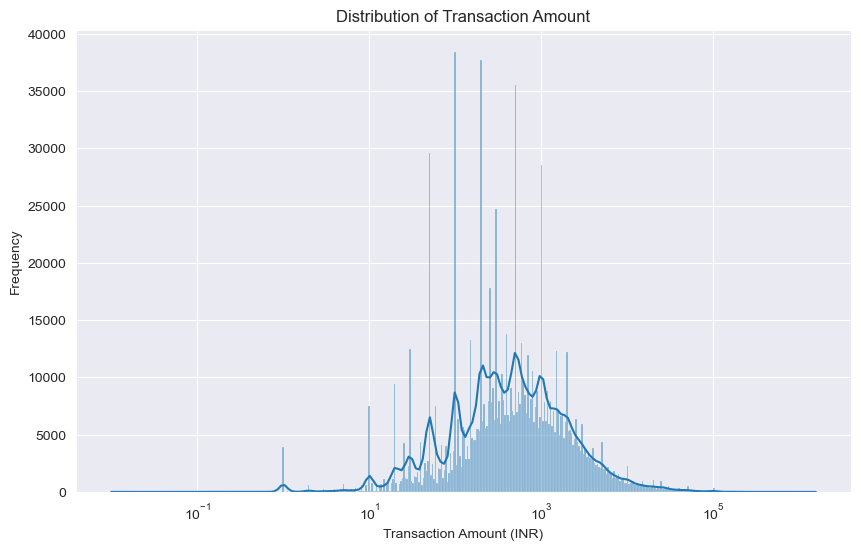

In [17]:
# To Easy to see the distribution, use log scale
# Therefore, use positive TransactionAmount only
positive_transactions = bank_customer[bank_customer['TransactionAmount (INR)'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(positive_transactions['TransactionAmount (INR)'], kde=True, log_scale=(True, False))
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount (INR)')
plt.ylabel('Frequency')
plt.show()

### 2. Distribution of Customer Account Balances

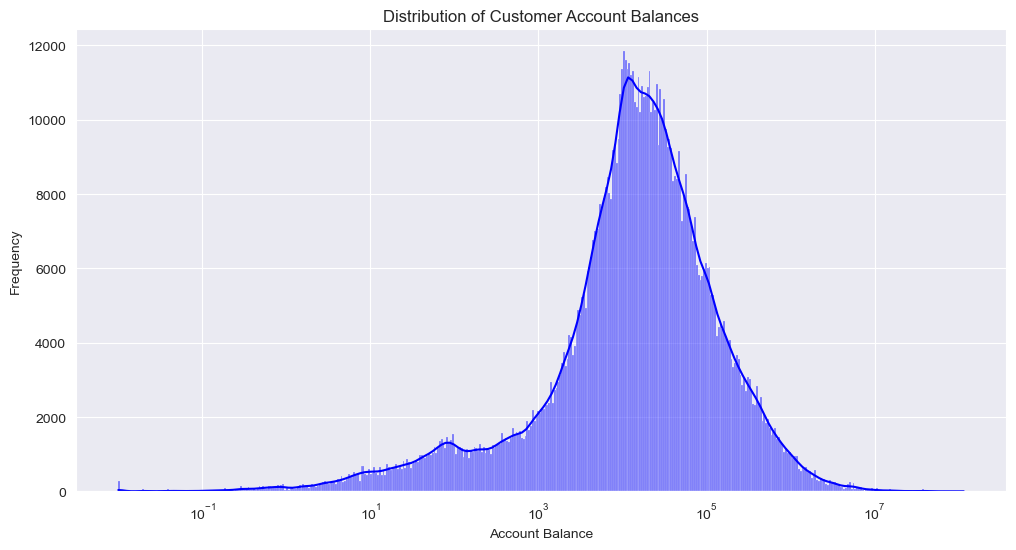

In [18]:
plt.figure(figsize=(12, 6))

positive_CustAccountBalance = bank_customer[bank_customer['CustAccountBalance'] > 0]

# Plotting the distribution of account balances
sns.histplot(positive_CustAccountBalance['CustAccountBalance'], kde=True, color='blue', log_scale=(True, False))
plt.title('Distribution of Customer Account Balances')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.show()

### 3. Distribution of Customer Gender

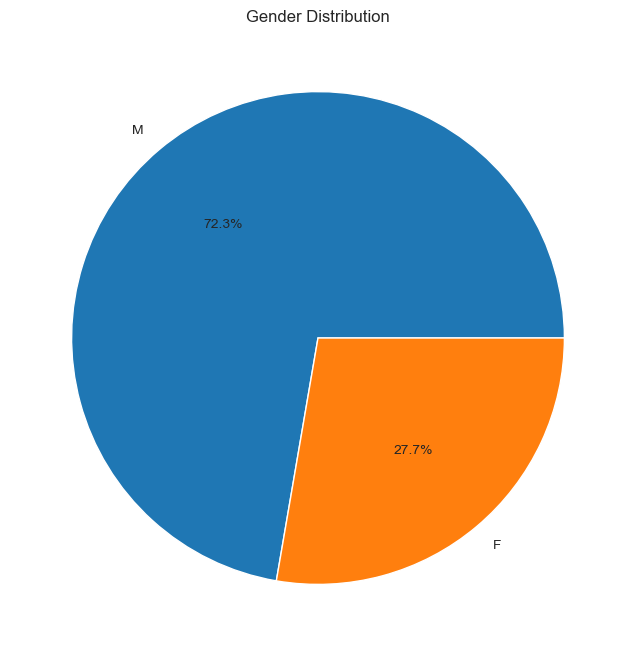

In [19]:
gender_counts = bank_customer['CustGender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

### 4. Distribution of Customer Age

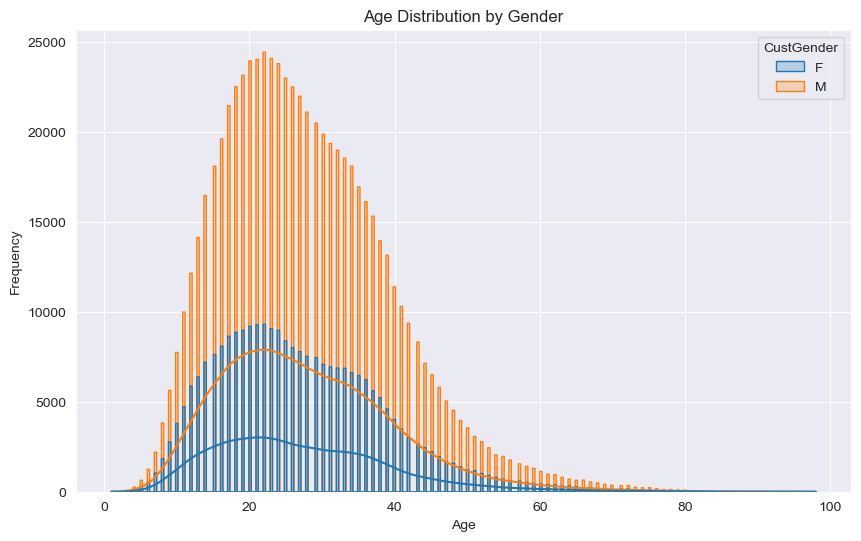

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(bank_customer, x='CustomerAge', hue='CustGender', kde=True, element='step')
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### 5. Customer Count and Total Account Balance in Top 50 Locations by Customer Count

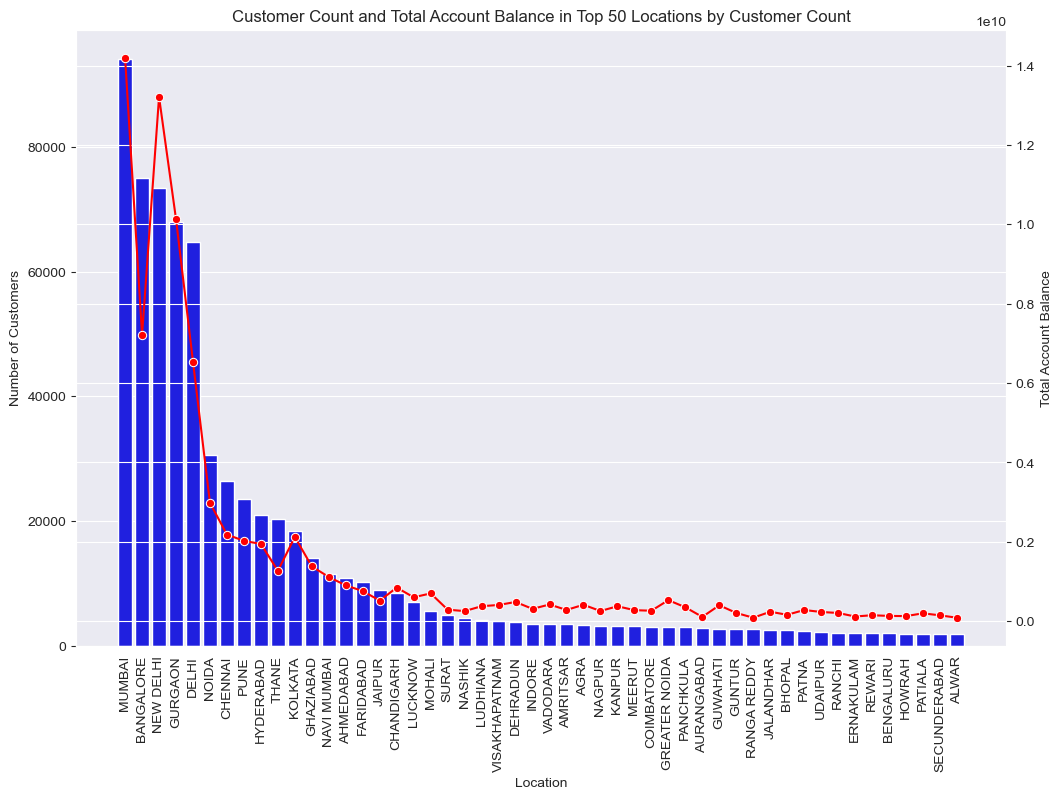

In [21]:
plt.figure(figsize=(12, 8))

# First, find the top 50 locations by number of customers
top_50_locations_by_customers = bank_customer.groupby('CustLocation').size().sort_values(ascending=False).head(50)

# Plot the number of customers using a bar chart
ax = sns.barplot(x=top_50_locations_by_customers.index, y=top_50_locations_by_customers.values, color='blue')
ax.set_ylabel('Number of Customers')
plt.xticks(rotation=90)

# Create a twin axis for the account balance
ax2 = ax.twinx()

# Get the total account balance for the top 50 locations
top_50_balance = bank_customer[bank_customer['CustLocation'].isin(top_50_locations_by_customers.index)].groupby('CustLocation')['CustAccountBalance'].sum()

# Ensure the order of locations matches with the first plot
top_50_balance = top_50_balance.reindex(top_50_locations_by_customers.index)

# Plot the account balance using a line chart
ax2 = sns.lineplot(x=top_50_balance.index, y=top_50_balance.values, marker='o', color='red', ax=ax2)
ax2.set_ylabel('Total Account Balance')

# Set titles and labels
plt.title('Customer Count and Total Account Balance in Top 50 Locations by Customer Count')
ax.set_xlabel('Location')

plt.show()


### 6. Transaction Volume by Hour of Day

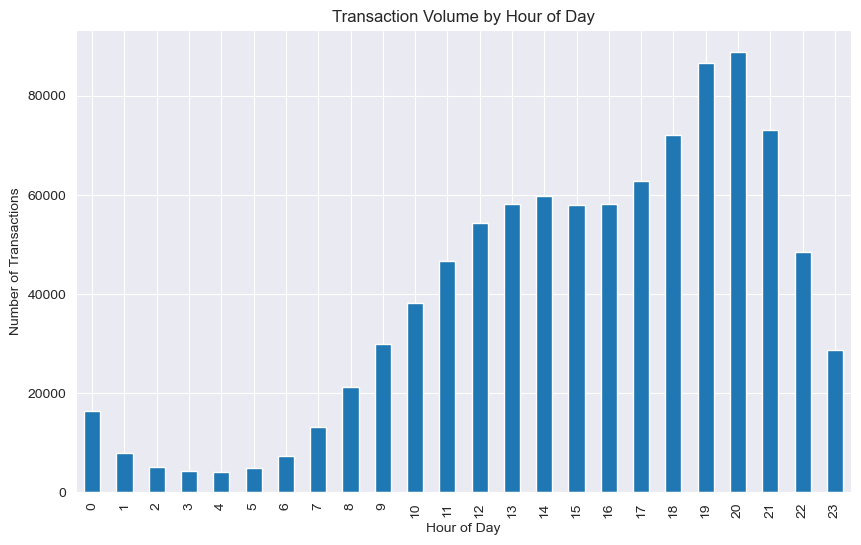

In [22]:
bank_customer['TransactionHour'] = bank_customer['TransactionDateTime'].dt.hour
hourly_transactions = bank_customer.groupby('TransactionHour').size()
hourly_transactions.plot(kind='bar', figsize=(10, 6))
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(24))
plt.show()


### 7. Relationship Between Transaction Amount and Account Balance by Gender

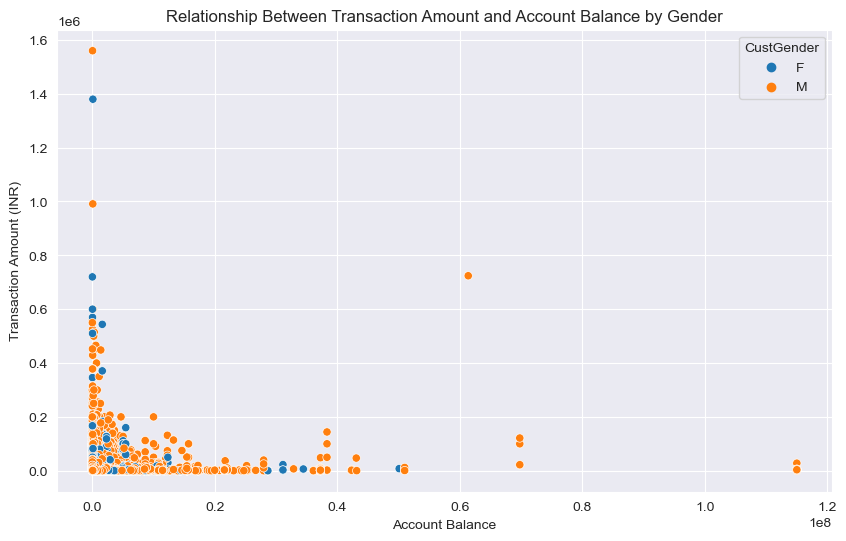

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', hue='CustGender', data=bank_customer)
plt.title('Relationship Between Transaction Amount and Account Balance by Gender')
plt.xlabel('Account Balance')
plt.ylabel('Transaction Amount (INR)')
plt.show()

### 8. Relationship Between Transaction Amount and Customer Age by Gender

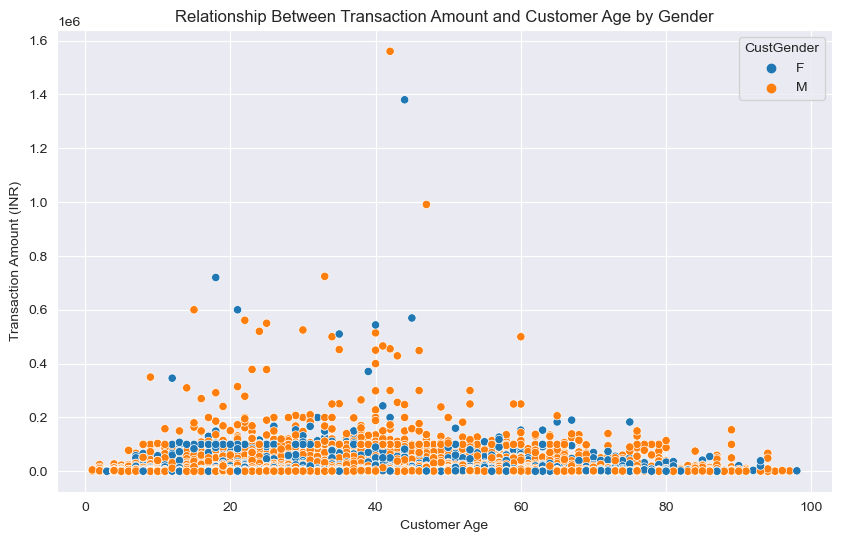

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustomerAge', y='TransactionAmount (INR)', hue='CustGender', data=bank_customer)
plt.title('Relationship Between Transaction Amount and Customer Age by Gender')
plt.xlabel('Customer Age')
plt.ylabel('Transaction Amount (INR)')
plt.show()

### 9. Relationship Between Account Balance and Customer Age by Gender

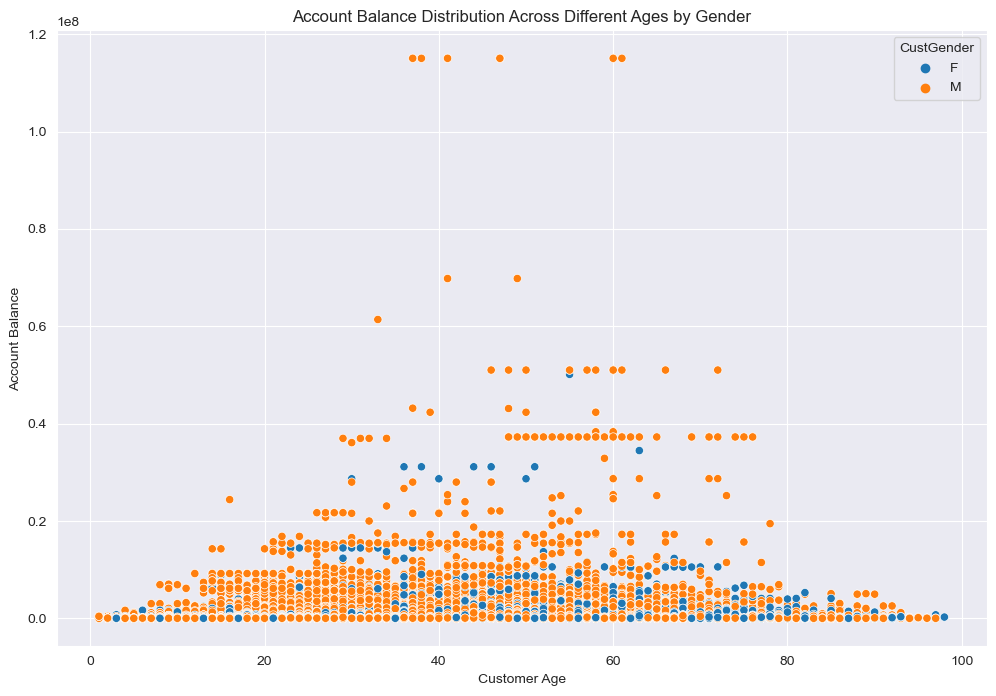

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CustomerAge', y='CustAccountBalance', hue='CustGender', data=bank_customer)
plt.title('Account Balance Distribution Across Different Ages by Gender')
plt.xlabel('Customer Age')
plt.ylabel('Account Balance')
plt.show()

### 10. Recency Distribution from RFM Analysis

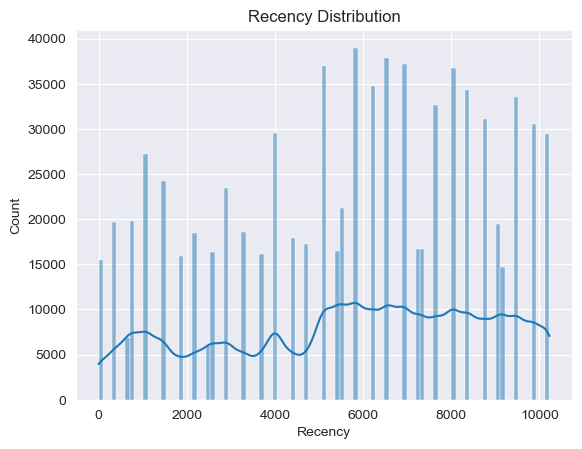

In [26]:
# Recency distribution
sns.histplot(rfm['Recency'], kde=True)
plt.title('Recency Distribution')
plt.show()

### 11. Frequency Distribution from RFM Analysis

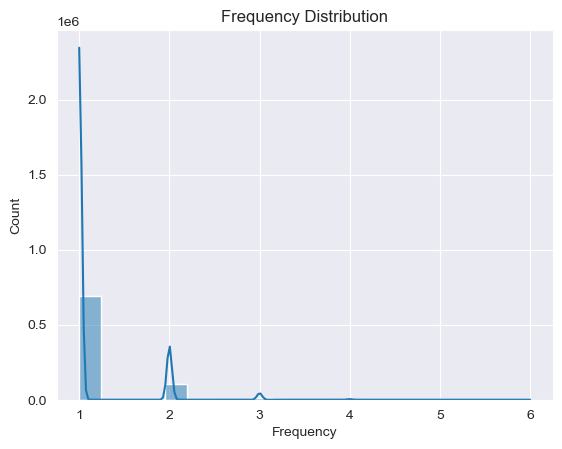

In [27]:
# Frequency distribution
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Frequency Distribution')
plt.show()

### 12. Monetary Distribution from RFM Analysis

Number of customers with zero monetary value: 505


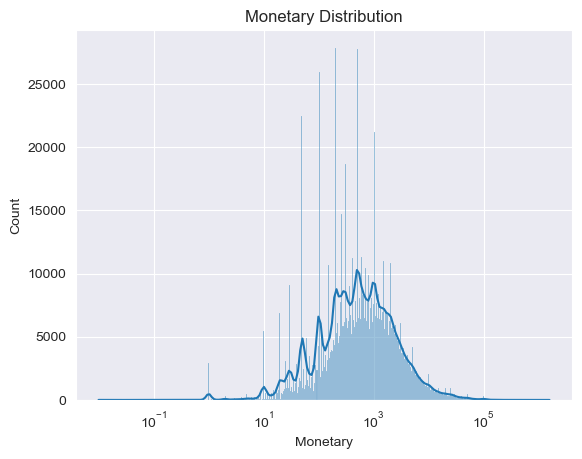

In [28]:
positive_rfm_monetary = rfm[rfm['Monetary'] > 0]
print("Number of customers with zero monetary value:", (rfm['Monetary'] == 0).sum())

# Monetary distribution
sns.histplot(positive_rfm_monetary['Monetary'], kde=True, log_scale=(True, False))
plt.title('Monetary Distribution')
plt.show()

## 5. Clustering using K-Means, Hierarchical, and DBSCAN

For K-Means and Hierarchical clustering, We used sample data to calculate the silhouette score, and then use the silhouette score to determine the number of clusters.

For K-Means, We Use the entire dataset to calculate the clusters.
For Hierarchical and DBSCAN, We use the sample data to calculate the clusters, since the entire dataset is too large to calculate.


In [29]:
# Choose the features for clustering
features = bank_customer[['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance']]

# Data scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# Sample the data to speed up the process
sample = bank_customer.sample(10000, random_state=50015940)

sample_features = sample[['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance']]
scaler_sample = StandardScaler()
scaled_features_sample = scaler_sample.fit_transform(sample_features)

### 1. K-Means Clustering

In [30]:
range_n_clusters = range(2, 10)
k_means_silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    k_means_cluster = KMeans(n_clusters=n_clusters, n_init=10, random_state=50015940)
    k_means_cluster_labels = k_means_cluster.fit_predict(scaled_features_sample)
    
    k_means_silhouette_avg = silhouette_score(scaled_features_sample, k_means_cluster_labels)
    k_means_silhouette_avg_scores.append(k_means_silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", k_means_silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.4864190664550146
For n_clusters = 3 The average silhouette_score is : 0.4919906020420901
For n_clusters = 4 The average silhouette_score is : 0.4908223870984238
For n_clusters = 5 The average silhouette_score is : 0.49781755901260166
For n_clusters = 6 The average silhouette_score is : 0.44727328706098207
For n_clusters = 7 The average silhouette_score is : 0.45118706904931777
For n_clusters = 8 The average silhouette_score is : 0.4349112320185488
For n_clusters = 9 The average silhouette_score is : 0.4623950225593313


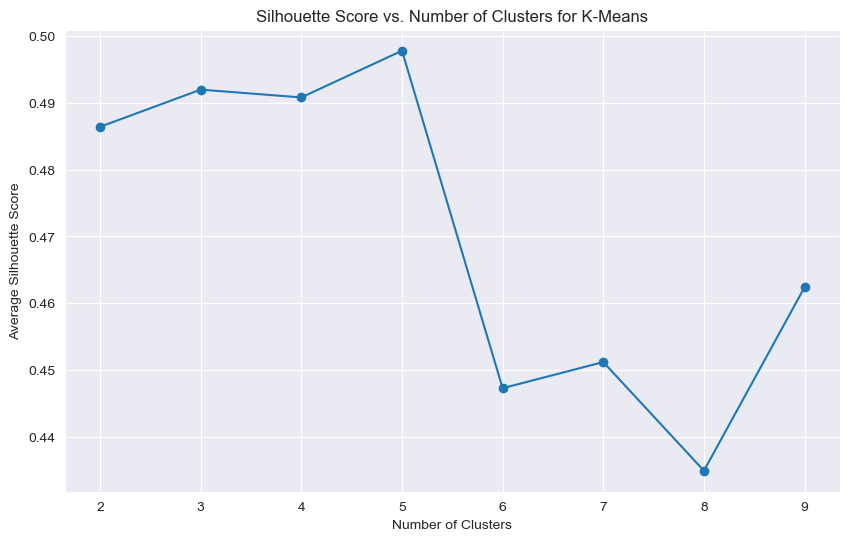

In [31]:
# Draw the relationship between the number of clusters and the silhouette score for K-Means
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, k_means_silhouette_avg_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

In [32]:
# As the silhouette score is the highest when the number of clusters is 5, we choose 5 as the number of clusters
kmeans = KMeans(n_clusters=5, n_init=10, random_state=50015940)
kmeans_clusters = kmeans.fit_predict(scaled_features)
bank_customer['kmeans_cluster'] = kmeans_clusters

### 2. Hierarchical Clustering

In [33]:
range_n_clusters = range(2, 10)
hierarchical_silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    hierarchical_cluster = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_cluster_labels = hierarchical_cluster.fit_predict(scaled_features_sample)
    
    hierarchical_silhouette_avg = silhouette_score(scaled_features_sample, hierarchical_cluster_labels)
    hierarchical_silhouette_avg_scores.append(hierarchical_silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", hierarchical_silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.48129455771318846
For n_clusters = 3 The average silhouette_score is : 0.48586054265749945
For n_clusters = 4 The average silhouette_score is : 0.4872125009866151
For n_clusters = 5 The average silhouette_score is : 0.49783069269501284
For n_clusters = 6 The average silhouette_score is : 0.5054978055202055
For n_clusters = 7 The average silhouette_score is : 0.5073019036379026
For n_clusters = 8 The average silhouette_score is : 0.3849033539940595
For n_clusters = 9 The average silhouette_score is : 0.3850520120603993


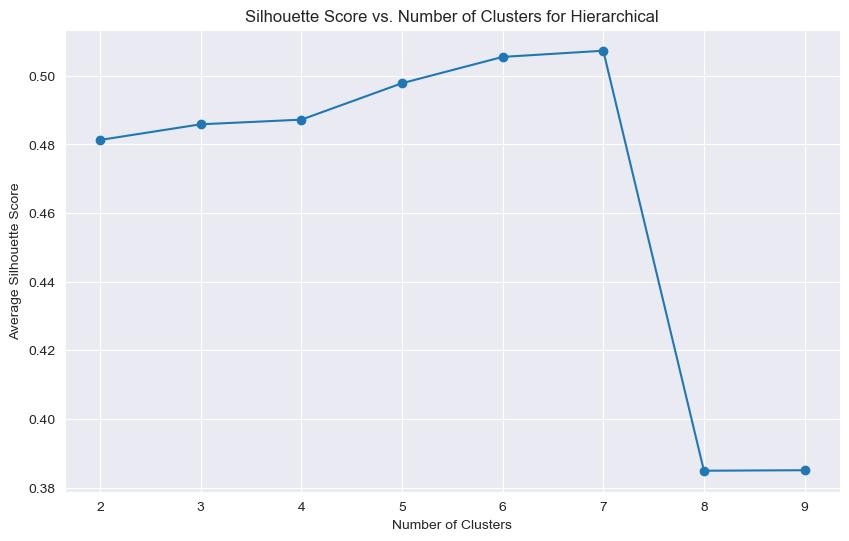

In [34]:
# Draw the relationship between the number of clusters and the silhouette score for Hierarchical
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, hierarchical_silhouette_avg_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters for Hierarchical')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

In [35]:
# As the silhouette score is the highest when the number of clusters is 7, we choose 7 as the number of clusters
hierarchical = AgglomerativeClustering(n_clusters=7)
hierarchical_clusters = hierarchical.fit_predict(scaled_features_sample)
sample['hierarchical_cluster'] = hierarchical_clusters

### 3. DBSCAN Clustering

In [36]:
# Using DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_features_sample)
sample['dbscan_cluster'] = dbscan_clusters

## 6. Visualization of Clusters

In [37]:
# Merge the scaled features and the clustering labels into a single DataFrame for K-Means
k_means_features_df = pd.DataFrame(scaled_features, columns=['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance'])
k_means_features_df['Cluster'] = kmeans_clusters

In [38]:
# Merge the scaled features and the clustering labels into a single DataFrame for Hierarchical
hierarchical_features_df = pd.DataFrame(scaled_features_sample, columns=['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance'])
hierarchical_features_df['Cluster'] = hierarchical_clusters

In [39]:
# Merge the scaled features and the clustering labels into a single DataFrame for DBSCAN
dbscan_features_df = pd.DataFrame(scaled_features_sample, columns=['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance'])
dbscan_features_df['Cluster'] = dbscan_clusters

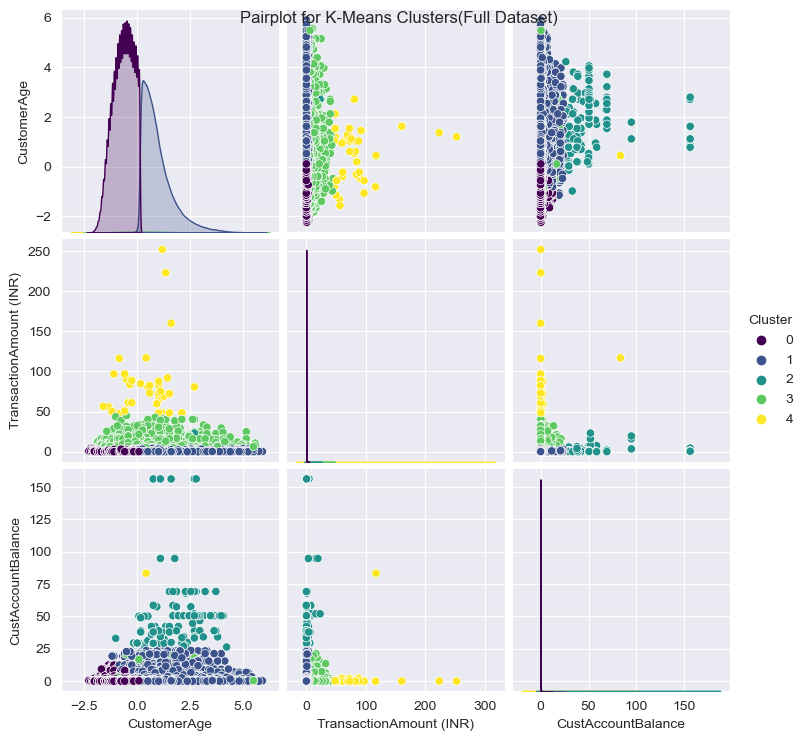

In [40]:
# Pairplot for K-Means Clusters
sns.pairplot(k_means_features_df, hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot for K-Means Clusters(Full Dataset)')
plt.show()

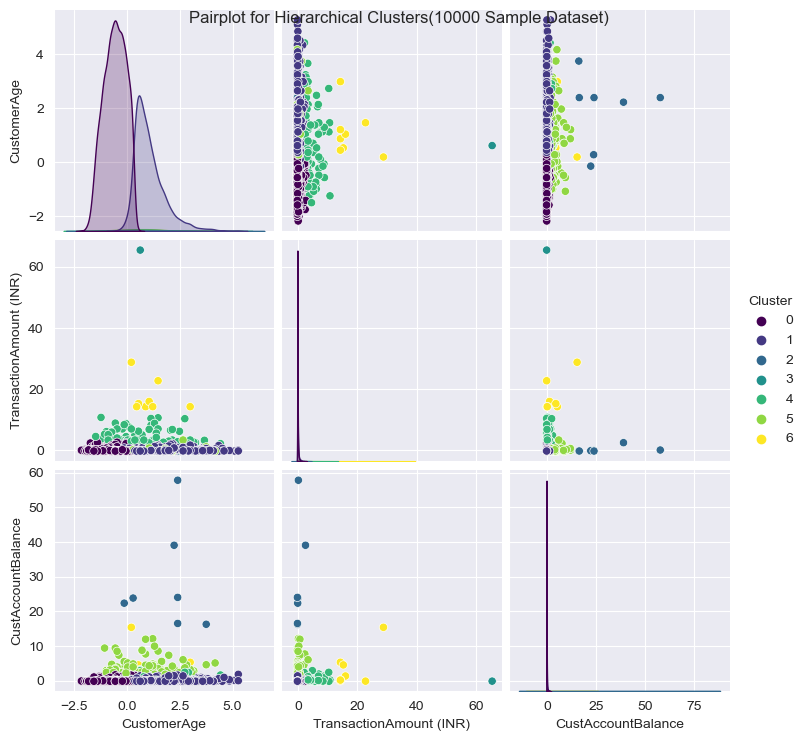

In [41]:
# Pairplot for Hierarchical Clusters
sns.pairplot(hierarchical_features_df, hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot for Hierarchical Clusters(10000 Sample Dataset)')
plt.show()

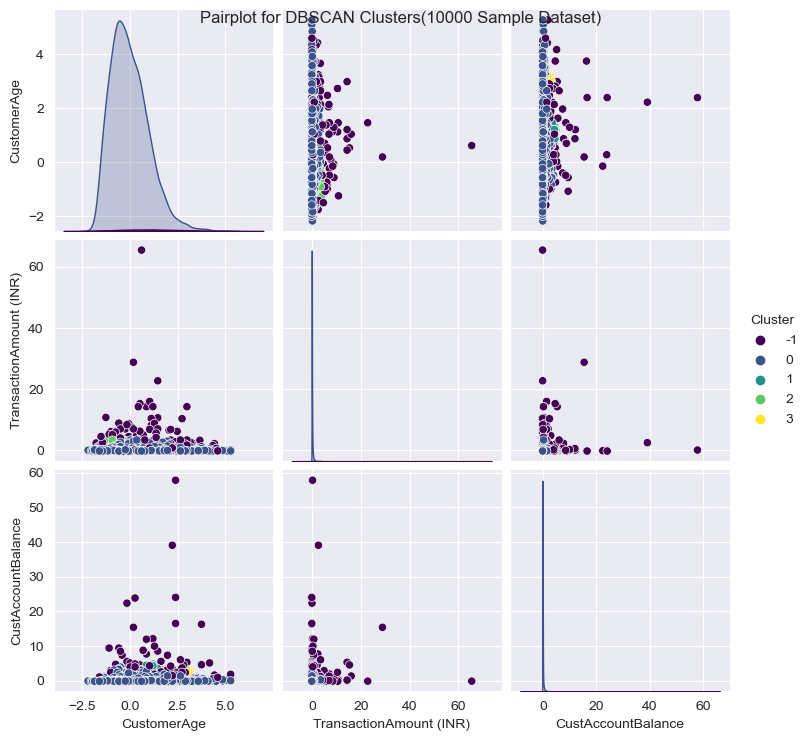

In [42]:
# Pairplot for DBSCAN Clusters
sns.pairplot(dbscan_features_df, hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot for DBSCAN Clusters(10000 Sample Dataset)')
plt.show()

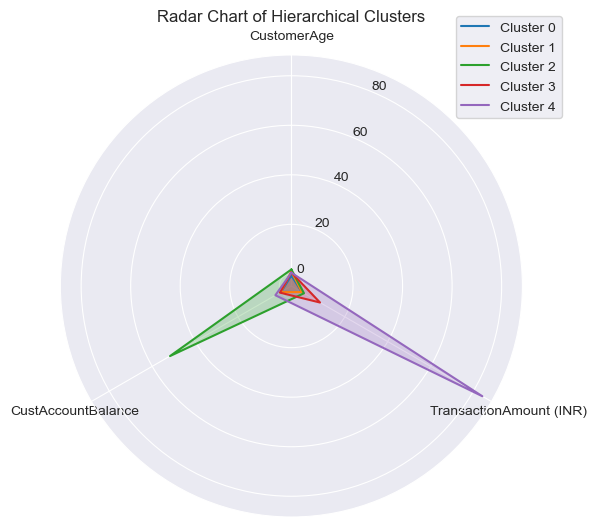

In [43]:
# Radar chart for K-Means Clusters
# Calculate the mean of each feature for each cluster
k_means_cluster_means = k_means_features_df.groupby('Cluster').mean()

# Radar chart parameters
num_vars = len(k_means_cluster_means.columns)
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for idx, row in k_means_cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label='Cluster {}'.format(idx))
    ax.fill(angles, values, alpha=0.25)

# Radar chart feature labels
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

labels = ['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance']
ax.set_xticks(angles[:-1])  # Set the ticks for the number of variables
ax.set_xticklabels(labels)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar Chart of Hierarchical Clusters')

plt.show()


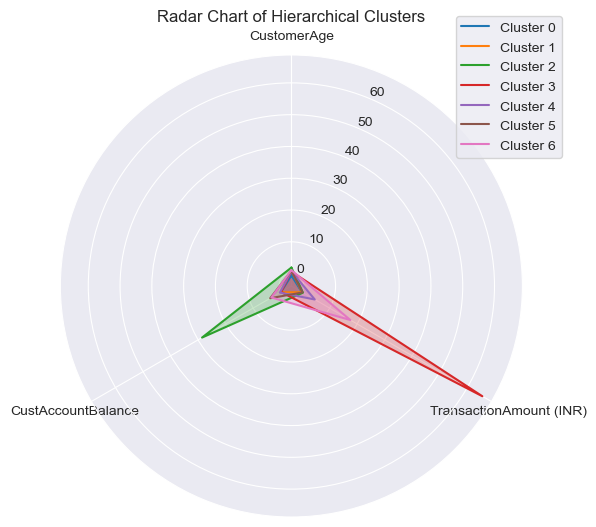

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# 计算每个聚类的特征平均值
hierarchical_cluster_means = hierarchical_features_df.groupby('Cluster').mean()

# Radar chart parameters
num_vars = len(hierarchical_cluster_means.columns)
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for idx, row in hierarchical_cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label='Cluster {}'.format(idx))
    ax.fill(angles, values, alpha=0.25)

# Radar chart feature labels
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

labels = ['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance']
ax.set_xticks(angles[:-1])  # Set the ticks for the number of variables
ax.set_xticklabels(labels)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar Chart of Hierarchical Clusters')

plt.show()


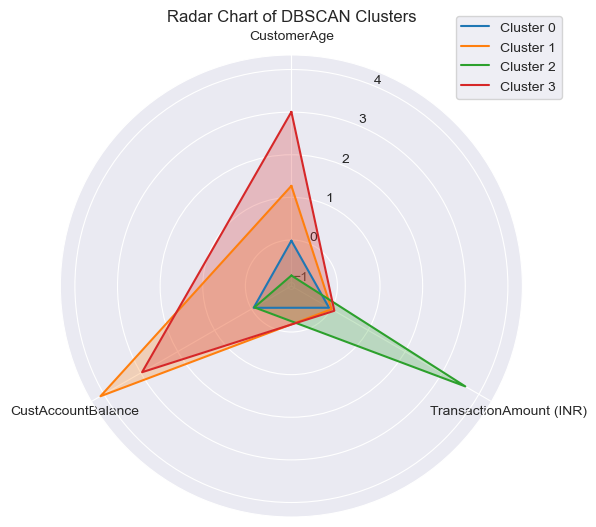

In [45]:
# Radar chart for DBSCAN Clusters
# 计算每个聚类（除噪声点外）的特征平均值
dbscan_cluster_means = dbscan_features_df[dbscan_features_df['Cluster'] != -1].groupby('Cluster').mean()

# Radar chart parameters
num_vars = len(dbscan_cluster_means.columns)
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for idx, row in dbscan_cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label='Cluster {}'.format(idx))
    ax.fill(angles, values, alpha=0.25)

# Radar chart feature labels
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

labels = ['CustomerAge', 'TransactionAmount (INR)', 'CustAccountBalance']
ax.set_xticks(angles[:-1])  # Set the ticks for the number of variables
ax.set_xticklabels(labels)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar Chart of DBSCAN Clusters')

plt.show()